<h1 style="color:#191970; font-size:38px">MIMO-NN1</h1>

<h1 style="color:#006400">Tools</h1>

<h1 style="color:#FF5733 ; font-size:15px"> CommPy</h1> is an open source toolkit implementing digital communications algorithms in Python using NumPy and SciPy.

In [1]:
pip install scikit-commpy

Note: you may need to restart the kernel to use updated packages.


<h1 style="color:#006400">Libraries</h1>

In [2]:
from statistics import mean
import numpy as np
from numpy.random import *
from numpy import *
from numpy.linalg import inv
from commpy.utilities import *
from commpy.modulation import QAMModem
from commpy.channels import *
from commpy.links import *
from math import *
import matplotlib.pyplot as plt
import time 

<h1 style="color:#006400">Functions</h1>

### 1. High Power Amplifier Output  

In [3]:
def hpa_sspa_modif_rapp(vin,Vsat,p,q,G,A,B): #cette fonction permet de calculer la sortie de l'amplificateur de puissance 
    #Le comportement PA non linéaire peut être décrit en utilisant les caractéristiques de compression AM-AM et de conversion AM-PM
    A=-345
    a0=abs(vin)
    theta=np.angle(vin)
    Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p))) #AM-AM est facilement obtenue via des mesures de puissance scalaire.
    Bm=(A*(a0**q))/((1+(a0/B)**(q)))#AM-PM est plus lourde, nécessitant des approches de détection de phase (mesures vectorielles).
    vout=Am*np.exp(1j*(theta+Bm))
    return(vout)
    

### 2. Non Linear Distortion Parameters  

In [4]:
def find_K0_sigma2_d(vin,vout): #D'apres la théorème de Bussgang, on peut décomposer le signal non linéaire
    #à la sortie PA en une fonction linéaire de l'entrée PA et un terme de distorsion non corrélé.
    # Le signal amplifié sera sous cette forme ymt = qmtxmt + dm
    K0 = np.mean(vout*np.conj(vin))/np.mean(np.absolute(vin)**2) # represente le gain complexe du PA
    sigma2_d = np.var(vout - K0*vin) #represente le vecteur distortion du PA
    return(K0,sigma2_d)

<h1 style="color:#006400">Basic PA Non linear Distortion Model </h1>

In [5]:
IBO=1 
p=1.1 #p est le facteur de lissage
Vsat=1.9 #Vsat est le niveau de saturation
G=16  #G est le petit gain de signal
A=-345 # A, B et q sont des paramètres d'ajustement
B=0.17
q=4
val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G) 
coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt(10**(-IBO/10)) #Calcul de coeffIBO
s=np.random.randn(1,1000000)
vin1 = np.sqrt(1/2)*(s+1j*s)   # amplification d'un signal aléatoire complexe
vin01 = coeff_IBO_m1dB*vin1
a0=np.absolute(vin01)
a02=a0**2  
theta=np.angle(vin01)
Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
Bm=(A*(a0**q))/((1+(a0/B)**(q)))
Sm=Am*np.exp(1j*(Bm))
vout1=Am*np.exp(1j*(theta+Bm))
K0 = np.mean(vout1*np.conj(vin01))/np.mean(np.absolute(vin01)**2)
sigma2_d = np.var(vout1 - K0*vin01) 
print(K0)
print(sigma2_d)

(12.804034357960463-0.44343761084051253j)
0.013572902343040375


<h1 style="color:#006400">Training Dataset </h1>

Generate 1000 H; 
For each H, we have 350000 S (input of NN1) and 350000 X_gd (output of NN1)

In [6]:
Mr=10  #nombre des antennes de reception
Mt=100  #nombre des antennes de transmission
M=16 
SNRdb=600 
N_bits=Mr*np.log2(M)
MSE=np.zeros((Mt,50))
x_gd_amp0=np.zeros((Mt,1))
y_gd_r0=np.zeros([Mt,100])
PAPR_GD=np.zeros((Mt,1))
MUIgdi= np.zeros((Mt,1))
SERgdi=np.zeros((Mt,1))
BERgdi=np.zeros((Mt,1))
GD_Execution_time=0
HH=np.zeros((1,2000))
S=np.zeros((400000,20))
ZZ=np.zeros((400000,10),dtype=complex)
Niter=50  # nbre d'itération pour que GD algo converge
mu1=0.0022 
lamda=0.00071
mu2=1
eps=1e-2
x_gd=np.zeros([Mt,1])
X_gd=np.zeros((400000,100))
gdx1=np.zeros([Mt,Niter])
d=np.zeros([Mt,1])
X=np.zeros((400000,200))
H=(1/np.sqrt(2*Mt))*(np.random.randn(Mr,Mt)+1j*np.random.randn(Mr,Mt)) # modeliser le canal par une matrice aleatoire complexe 
HR=H.flatten() # transforme la matrice en un vecteur 
realh=np.real(HR) 
imagh=np.imag(HR)
Hr=np.concatenate((realh,imagh),axis=0).reshape(-1,1) # Concatener les valeurs réels et imaginaires de H en un seul vecteur 
Hr=np.reshape(Hr, (2000, 1)).T
HH=Hr
for j in range(400000):
    bits = np.random.randint(2, size=int(N_bits)) # génerer des bits aleatoires 
    QAM16 = QAMModem(16) # Effectuer 16_QAM modulation 
    z=QAM16.modulate(bits) # Contient les symboles 
    Z = np.reshape(z, (1, 10)).T
    ZZ[j]=Z.T
    reals=np.real(Z.T)
    imags=np.imag(Z.T)
    s=np.concatenate((reals,imags),axis=1) # former un vecteur de taille 20 
    S[j]=s
    ## CDm algo
    for i in range(Niter):
        gdx1=2*np.conj(K0*np.transpose(H)).dot(K0*H.dot(x_gd)+H.dot(d)-Z) 
        x_gd=x_gd-mu1*gdx1
        realx=np.real( x_gd)
        imagx=np.imag( x_gd)
        x_z=np.concatenate((realx,imagx),axis=0).T
        X[j]=x_z
        ## HPA 
        val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
        coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(x_gd)))*np.sqrt(10**(-IBO/10)) # ajuster les coeff IBO 
        vin2=coeff_IBO_m1dB*x_gd 
        vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B) #amplifier le signal de sortie de GD Algo
        K0,sigma2_d=find_K0_sigma2_d (vin2,vout2)
        d=vout2-K0*vin2 # Calculer le vecteur distortion 
        y_gd =np.array(vout2/coeff_IBO_m1dB) #normalization
       

<h1 style="color:#006400"> Data Normalization </h1>

In [7]:
#Base d'apprentissage 
X_train=S[:350000,:] 
y_train=X[:350000,:]
#Base de test 
X_test=S[350000:,:]
y_test=X[350000:,:] 


<h1 style="color:#006400"> Artifical Neural Network</h1>

In [10]:
from keras import backend as 

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) # les erreurs sont quadrillés avant la moyenne.

In [106]:
import tensorflow as tf
import keras.backend as K

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def NMSE(y_true, y_pred):
    NMS=K.zeros(shape=(1000))
    NMSEdb=K.zeros(shape=(1000))
    y_predt=tf.convert_to_tensor(y_pred,dtype=tf.float32) 
    Y_gdr=y_predt[:1000,:100] #récuperer la partie réelle de y_pred
    Y_gdi=y_predt[:1000,100:] #récuperer la partie imaginaire de y_pred
    Y_gd=tf.complex(Y_gdr,Y_gdi) 
    X_testt=tf.convert_to_tensor(X_train,dtype=tf.float32)
    Shr=X_testt[:1000,:10]
    Shi=X_testt[:1000,10:20]
    SSh=tf.complex(Shr,Shi)
    NMSE=[]
    for i in range(1000):
        val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
        coeff_IBO_m1dB=val_IBO_m1dB*tf.math.sqrt((1/K.var(Y_gd[i])))*np.sqrt(10**(-IBO/10)) #Ajuster les coeff IBO
        vin2=coeff_IBO_m1dB*Y_gd[i] # Amplifier le signal Predit
        A=-345
        a0=K.abs(vin2)
        theta=tf.math.angle(vin2)
        Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
        Bm=(A*(a0**q))/((1+(a0/B)**(q)))
        vout2=tf.complex(Am,0.0)*tf.math.exp(tf.complex(0.0,theta+Bm))
        Y_gd_amp = vout2/coeff_IBO_m1dB
        Y_gd_amp0=K.reshape(Y_gd_amp,(100,1))
        HH=K.constant(H,dtype=complex64)
        recieveh=K.dot(HH,(Y_gd_amp0)) # multiplier le signal prédit par le canal H
        recievehh=K.reshape(recieveh,(1,10))
        NMS=K.mean(K.abs(tf.math.subtract(recievehh,SSh[i])**2))/K.mean(K.abs(SSh[i])**2) #Calcul d'NMSE
        NMSEdb=10*log10(K.mean(NMS)) #Transformation en db 
    return NMSEdb
        

In [119]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
import matplotlib.pyplot as plt
model = Sequential()
#keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.1, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
model.add(Dense(units =200, kernel_initializer = 'uniform', activation = 'relu', input_dim =20))
model.add(Dense(units =200, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units =200, kernel_initializer = 'uniform', activation = 'selu'))
model.compile(optimizer = 'Adamax', loss = 'mae', metrics = [root_mean_squared_error])
history=model.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=10000, epochs=4000, shuffle=True)
# Valider le model par le données de test 
# Make predictions
y_pred= model.predict(X_train) 
y_pred_test = model.predict(X_test)

Train on 350000 samples, validate on 50000 samples
Epoch 1/4000
350000/350000 [==============================] - 1077s 3ms/step - loss: 0.0266 - root_mean_squared_error: 0.0337 - val_loss: 0.0122 - val_root_mean_squared_error: 0.0154
Epoch 2/4000
350000/350000 [==============================] - 8s 23us/step - loss: 0.0089 - root_mean_squared_error: 0.0112 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0089
Epoch 3/4000
350000/350000 [==============================] - 8s 23us/step - loss: 0.0066 - root_mean_squared_error: 0.0083 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0079
Epoch 4/4000
350000/350000 [==============================] - 8s 24us/step - loss: 0.0061 - root_mean_squared_error: 0.0076 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0074
Epoch 5/4000
350000/350000 [==============================] - 8s 23us/step - loss: 0.0058 - root_mean_squared_error: 0.0073 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0071
Epoch 6/4000
350000/350000 [==============

350000/350000 [==============================] - 8s 22us/step - loss: 0.0036 - root_mean_squared_error: 0.0047 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0046
Epoch 46/4000
350000/350000 [==============================] - 7s 20us/step - loss: 0.0036 - root_mean_squared_error: 0.0046 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0046
Epoch 47/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0036 - root_mean_squared_error: 0.0046 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0046
Epoch 48/4000
350000/350000 [==============================] - 6s 19us/step - loss: 0.0036 - root_mean_squared_error: 0.0046 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0046
Epoch 49/4000
350000/350000 [==============================] - 7s 19us/step - loss: 0.0035 - root_mean_squared_error: 0.0046 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0046
Epoch 50/4000
350000/350000 [==============================] - 7s 19us/step - loss: 0.0035 - root_mean_s

350000/350000 [==============================] - 6s 17us/step - loss: 0.0030 - root_mean_squared_error: 0.0040 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0040
Epoch 91/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0030 - root_mean_squared_error: 0.0039 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0040
Epoch 92/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0030 - root_mean_squared_error: 0.0039 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0040
Epoch 93/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0030 - root_mean_squared_error: 0.0039 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0039
Epoch 94/4000
350000/350000 [==============================] - 8s 22us/step - loss: 0.0030 - root_mean_squared_error: 0.0039 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0039
Epoch 95/4000
350000/350000 [==============================] - 8s 22us/step - loss: 0.0030 - root_mean_s

350000/350000 [==============================] - 6s 18us/step - loss: 0.0027 - root_mean_squared_error: 0.0035 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0035
Epoch 135/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0027 - root_mean_squared_error: 0.0036 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0036
Epoch 136/4000
350000/350000 [==============================] - 6s 17us/step - loss: 0.0027 - root_mean_squared_error: 0.0035 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0035
Epoch 137/4000
350000/350000 [==============================] - 6s 17us/step - loss: 0.0027 - root_mean_squared_error: 0.0035 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0035
Epoch 138/4000
350000/350000 [==============================] - 6s 17us/step - loss: 0.0026 - root_mean_squared_error: 0.0035 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0035
Epoch 139/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0026 - root_m

350000/350000 [==============================] - 6s 18us/step - loss: 0.0024 - root_mean_squared_error: 0.0032 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0032
Epoch 179/4000
350000/350000 [==============================] - 6s 17us/step - loss: 0.0024 - root_mean_squared_error: 0.0032 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0032
Epoch 180/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0024 - root_mean_squared_error: 0.0032 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0031
Epoch 181/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0024 - root_mean_squared_error: 0.0032 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0032
Epoch 182/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0024 - root_mean_squared_error: 0.0031 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0031
Epoch 183/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0024 - root_m

350000/350000 [==============================] - 7s 19us/step - loss: 0.0022 - root_mean_squared_error: 0.0029 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0029
Epoch 223/4000
350000/350000 [==============================] - 7s 20us/step - loss: 0.0022 - root_mean_squared_error: 0.0029 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0029
Epoch 224/4000
350000/350000 [==============================] - 7s 19us/step - loss: 0.0022 - root_mean_squared_error: 0.0029 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0029
Epoch 225/4000
350000/350000 [==============================] - 7s 20us/step - loss: 0.0021 - root_mean_squared_error: 0.0028 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0029
Epoch 226/4000
350000/350000 [==============================] - 7s 21us/step - loss: 0.0021 - root_mean_squared_error: 0.0028 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0029
Epoch 227/4000
350000/350000 [==============================] - 7s 21us/step - loss: 0.0021 - root_m

Epoch 267/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0020 - root_mean_squared_error: 0.0027 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0027
Epoch 268/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0020 - root_mean_squared_error: 0.0027 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0027
Epoch 269/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0020 - root_mean_squared_error: 0.0027 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0027
Epoch 270/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0020 - root_mean_squared_error: 0.0027 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0027
Epoch 271/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0020 - root_mean_squared_error: 0.0027 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0027
Epoch 272/4000
350000/350000 [==============================] - 6s 18us/step - loss: 

Epoch 312/4000
350000/350000 [==============================] - 7s 19us/step - loss: 0.0020 - root_mean_squared_error: 0.0026 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0026
Epoch 313/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0020 - root_mean_squared_error: 0.0026 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0026
Epoch 314/4000
350000/350000 [==============================] - 7s 19us/step - loss: 0.0019 - root_mean_squared_error: 0.0026 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0026
Epoch 315/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0020 - root_mean_squared_error: 0.0026 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0026
Epoch 316/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0019 - root_mean_squared_error: 0.0026 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0026
Epoch 317/4000
350000/350000 [==============================] - 7s 19us/step - loss: 

350000/350000 [==============================] - 7s 19us/step - loss: 0.0019 - root_mean_squared_error: 0.0026 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0026
Epoch 357/4000
350000/350000 [==============================] - 7s 19us/step - loss: 0.0019 - root_mean_squared_error: 0.0026 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0026
Epoch 358/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0019 - root_mean_squared_error: 0.0026 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0026
Epoch 359/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0019 - root_mean_squared_error: 0.0025 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 360/4000
350000/350000 [==============================] - 7s 19us/step - loss: 0.0019 - root_mean_squared_error: 0.0025 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0026
Epoch 361/4000
350000/350000 [==============================] - 7s 19us/step - loss: 0.0019 - root_m

Epoch 401/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0019 - root_mean_squared_error: 0.0025 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0025
Epoch 402/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0019 - root_mean_squared_error: 0.0025 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0026
Epoch 403/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0019 - root_mean_squared_error: 0.0025 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0025
Epoch 404/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0019 - root_mean_squared_error: 0.0025 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0025
Epoch 405/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0019 - root_mean_squared_error: 0.0025 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0025
Epoch 406/4000
350000/350000 [==============================] - 6s 18us/step - loss: 

350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0025 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 446/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0025 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0025
Epoch 447/4000
350000/350000 [==============================] - 7s 19us/step - loss: 0.0018 - root_mean_squared_error: 0.0025 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0025
Epoch 448/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0025 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 449/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0025 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 450/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_m

Epoch 490/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0025 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 491/4000
350000/350000 [==============================] - 6s 19us/step - loss: 0.0018 - root_mean_squared_error: 0.0025 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 492/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0025 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 493/4000
350000/350000 [==============================] - 7s 19us/step - loss: 0.0018 - root_mean_squared_error: 0.0025 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 494/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0025 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 495/4000
350000/350000 [==============================] - 6s 18us/step - loss: 

Epoch 535/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0024 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 536/4000
350000/350000 [==============================] - 7s 19us/step - loss: 0.0018 - root_mean_squared_error: 0.0024 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0024
Epoch 537/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0025 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 538/4000
350000/350000 [==============================] - 6s 17us/step - loss: 0.0018 - root_mean_squared_error: 0.0024 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0024
Epoch 539/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0025 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 540/4000
350000/350000 [==============================] - 6s 19us/step - loss: 

Epoch 580/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0024 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 581/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0024 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0024
Epoch 582/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0024 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0025
Epoch 583/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0024 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0024
Epoch 584/4000
350000/350000 [==============================] - 6s 18us/step - loss: 0.0018 - root_mean_squared_error: 0.0024 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0024
Epoch 585/4000
350000/350000 [==============================] - 6s 18us/step - loss: 

Epoch 625/4000
350000/350000 [==============================] - 8s 22us/step - loss: 0.0017 - root_mean_squared_error: 0.0024 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0024
Epoch 626/4000
350000/350000 [==============================] - 7s 20us/step - loss: 0.0017 - root_mean_squared_error: 0.0024 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0024
Epoch 627/4000
350000/350000 [==============================] - 6s 17us/step - loss: 0.0018 - root_mean_squared_error: 0.0024 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0024
Epoch 628/4000
350000/350000 [==============================] - 6s 16us/step - loss: 0.0018 - root_mean_squared_error: 0.0024 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0024
Epoch 629/4000
350000/350000 [==============================] - 5s 14us/step - loss: 0.0017 - root_mean_squared_error: 0.0024 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0024
Epoch 630/4000
350000/350000 [==============================] - 5s 15us/step - loss: 

KeyboardInterrupt: 


# <h1 style="color:#006400"> Weights Vector of NN1</h1>

In [ ]:
first_layer_weights =model.layers[0].get_weights()[0] 
first=first_layer_weights.flatten()
first_layer_biases  = model.layers[0].get_weights()[1]
first_layer=np.concatenate((first,first_layer_biases),axis=0) #transformer les poids et biais de la 1ere couche en un seul vecteur 
second_layer_weights = model.layers[1].get_weights()[0]
second=second_layer_weights.flatten()
second_layer_biases  = model.layers[1].get_weights()[1]
second_layer=np.concatenate((second,second_layer_biases),axis=0) #transformer les poids et biais de la 2eme couche en un seul vecteur 
weights=np.concatenate((first_layer,second_layer),axis=0) 
print (len(weights))

<h1 style="color:#006400"> Make Predictions</h1>

In [120]:
y_pred= model.predict(X_train)
y_pred_test = model.predict(X_test)


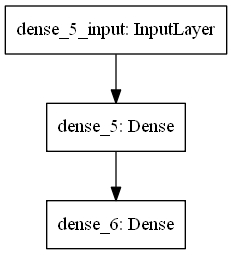

In [19]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

<h1 style="color:#006400"> Mean-Squared-Error</h1>

# Test Set 

Mean Squred Error: -29.03835822671519
[ 2.89395777-2.99996475j  1.04961484+3.01183372j -0.95497048+1.09638227j
  1.01027845+2.88096441j -1.06646216-2.85643012j  0.92133513+3.12957674j
  2.96375583+3.00137561j -0.92428548-2.92094383j  0.95727984+1.06384606j
  0.99483073-3.05151428j]


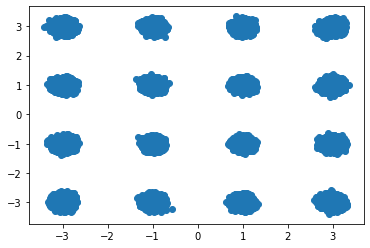

In [121]:
# Calcul l' NMSE de données de test qui sont de taille 50000*200 ;200 car réels et imaginaires 
NMSE=np.zeros([50000,1])
recievehh=np.zeros([50000,10],dtype=complex)
Y_gdr=y_pred_test[:50000,:100]
Y_gdi=1j*y_pred_test[:50000,100:]
Y_gd=Y_gdr+Y_gdi
Shr=X_test[:50000,:10]
Shi=1j*X_test[:50000,10:20]
SSh=Shr+Shi
for i in range(50000):
    val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
    coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(Y_gd[i])))*np.sqrt(10**(-IBO/10))
    vin2=coeff_IBO_m1dB*Y_gd[i]
    vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
    Y_gd_amp = vout2/coeff_IBO_m1dB
    recieveh=(H.dot(Y_gd_amp)).reshape((10))
    recievehh[i]=recieveh
    NMSE[i]=(np.mean(np.abs(SSh[i]-recieveh)**2)/np.mean(np.abs(SSh[i])**2))
    NMSEdb=10*np.log10(np.mean(NMSE))
recievehhh=recievehh.flatten()
realr=np.real(recievehhh)
imagr=np.imag(recievehhh)
plt.scatter(realr,imagr) 
print('Mean Squred Error:', NMSEdb)

Mean Squred Error: -42.5827566732019
[[ 1.+3.j -3.-3.j -1.-1.j ...  3.-1.j  3.-1.j  1.+3.j]
 [ 1.-1.j -3.+3.j -3.+1.j ... -3.+3.j -1.+1.j  3.-1.j]
 [ 1.+3.j  1.-1.j -3.-1.j ...  3.+1.j -1.+1.j  1.+1.j]
 ...
 [-1.+1.j  1.-3.j  3.-1.j ...  1.+3.j -3.+1.j -3.-1.j]
 [-1.+3.j -3.-1.j  3.+3.j ...  1.-1.j  3.-3.j -3.+1.j]
 [ 3.-3.j  1.+3.j -1.+1.j ... -1.-3.j  1.+1.j  1.-3.j]]


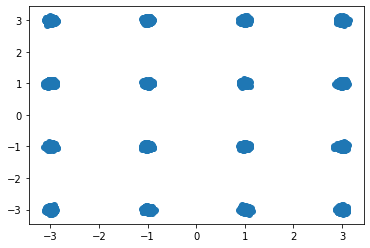

In [94]:
# #ici lorsque de prend y_test au lieu de y_pred_test pour le calcul d'NMSE qui nous donne un NMSE de l'ordre de -42 db  
recievehh=np.zeros([50000,10],dtype=complex)
Y_gdr=y_test[:,:100]
Y_gdi=1j*y_test[:,100:]
Y_gd=Y_gdr+Y_gdi
Shr=X_test[:,:10]
Shi=1j*X_test[:,10:20]
SSh=Shr+Shi
for i in range(50000):
    val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
    coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(Y_gd[i])))*np.sqrt(10**(-IBO/10))
    vin2=coeff_IBO_m1dB*Y_gd[i]
    vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
    Y_gd_amp = vout2/coeff_IBO_m1dB
    recieveh=(H.dot(Y_gd_amp)).reshape((10))
    recievehh[i]=recieveh
    NMSE=(np.mean(np.abs(SSh[i]-recieveh)**2)/np.mean(np.abs(SSh[i])**2))
    NMSEdb=10*np.log10(np.mean(NMSE))
recievehhh=recievehh.flatten()
realr=np.real(recievehhh)
imagr=np.imag(recievehhh)
plt.scatter(realr,imagr) 

print('Mean Squred Error:', NMSEdb)
